In [1]:
import sys
sys.path.append('..')
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
np.warnings.filterwarnings('ignore')
import matplotlib
from matplotlib import pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import time
from titration import *
from bindingmodels import *


## preparation
let's get a protein stock and a ligand stock, as well as an empty cell

In [2]:
protein_stock = Solution(conc_p=0.1, d_conc_p=1e-2)
ligand_stock = Solution(conc_l=0.1, d_conc_l=1e-2)
complex_stock = Solution(conc_l=0.1, d_conc_l=1e-2, conc_p=0.1, d_conc_p=1e-2)

we need two wells, one to put ligand solution, one for protein-ligand complex

In [3]:
well_complex = SingleWell()
well_ligand = SingleWell()

## titration

This should model the real process of how the protein and ligand solutions were prepared.

In [4]:
# put ligand solution in both wells
for idx in range(10):
    well_complex.inject(complex_stock, 1, 1e-3)
    well_ligand.inject(ligand_stock, 1, 1e-3)

../titration.py:113: RuntimeWarning: divide by zero encountered in power
  volume_scaling = np.expand_dims(self.vols, axis=1).dot(np.expand_dims(np.power(self.vols, -1), axis=1).transpose())
../titration.py:113: RuntimeWarning: divide by zero encountered in power
  volume_scaling = np.expand_dims(self.vols, axis=1).dot(np.expand_dims(np.power(self.vols, -1), axis=1).transpose())
../titration.py:113: RuntimeWarning: divide by zero encountered in power
  volume_scaling = np.expand_dims(self.vols, axis=1).dot(np.expand_dims(np.power(self.vols, -1), axis=1).transpose())
../titration.py:113: RuntimeWarning: divide by zero encountered in power
  volume_scaling = np.expand_dims(self.vols, axis=1).dot(np.expand_dims(np.power(self.vols, -1), axis=1).transpose())
../titration.py:113: RuntimeWarning: divide by zero encountered in power
  volume_scaling = np.expand_dims(self.vols, axis=1).dot(np.expand_dims(np.power(self.vols, -1), axis=1).transpose())
../titration.py:113: RuntimeWarning: divide b

In [5]:
well_complex.select_non_zero()
well_ligand.select_non_zero()

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]


To make life easier, we pre-calculate what the fluorescence intensities should look like, roughly.

In [6]:
# let's say:
delta_g_truth = -5.0 #kT

In [7]:
well_complex_concs_p_truth = well_complex.concs[0]
well_complex_concs_l_truth = well_complex.concs[1]
concs_p_truth, concs_l_truth, concs_pl_truth = TwoComponentBindingModel.equilibrium_concentrations(
            delta_g_truth, well_complex_concs_p_truth, well_complex_concs_l_truth)


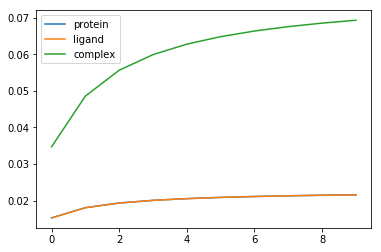

In [8]:
plt.clf()
plt.plot(concs_p_truth, label='protein')
plt.plot(concs_l_truth, label='ligand')
plt.plot(concs_pl_truth, label='complex')
plt.legend()

Let's arbitrarily make some fluorescence constants.

In [9]:
fi_p_truth = 0.2
fi_l_truth = 0.1
fi_pl_truth = 0.5
fi_plate_truth = 0.01
fi_buffer_truth = 0.01
cell_length = 1

In [10]:
fi_complex_truth = fi_p_truth * concs_p_truth + fi_l_truth * concs_l_truth + fi_pl_truth * concs_pl_truth + fi_buffer_truth * cell_length + fi_plate_truth
fi_ligand_truth = fi_l_truth * concs_l_truth + fi_pl_truth * concs_pl_truth + fi_buffer_truth * cell_length + fi_plate_truth

The world isn't perfect, so let's add some noise.

In [11]:
fi_complex = fi_complex_truth + np.random.normal(0, 0.01, fi_complex_truth.shape[0])
fi_ligand = fi_ligand_truth + np.random.normal(0, 0.01, fi_ligand_truth.shape[0])
print(fi_complex)
print(fi_ligand)

[0.05150756 0.05567439 0.03750812 0.06226779 0.06830679 0.05069327
 0.05322729 0.04854635 0.05713632 0.06751546]
[0.03804662 0.05344755 0.05221734 0.06090406 0.06203444 0.044576
 0.05418645 0.05761883 0.06086802 0.05035493]


Start to do some inference.

In [12]:
rv = well_complex.concs_p_rv
from sklearn import *
from mpl_toolkits.mplot3d import Axes3D

/Users/yuanqingwang/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yuanqingwang/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/yuanqingwang/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yuanqingwang/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/yuanqingwang/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, fallin

In [14]:
from inference import *
chain_states, kernel_results, rvs, trajs = make_model(well_complex, well_ligand, fi_complex, fi_ligand, debug=True, kernel='hamiltonian_monte_carlo')

tf.Tensor(
[0.06665994 0.00336795 0.05567477 0.01949537 0.03263751 0.04674208
 0.05279234 0.02744639 0.04588015 0.00136394], shape=(10,), dtype=float32)


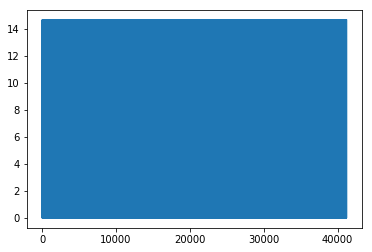

In [15]:
traj = trajs[1]
rv = rvs[1]
print(rv.sample(10))
plt.plot([np.exp(rv.log_prob(tf.constant(traj[idx], dtype=tf.float32))) for idx in range(len(traj))])
# ax, pca = plot_rv(rv)
# rv_ax = plot_est(traj, rv, ax, pca = pca)
# plot_all(traj, rv)

In [16]:
for idx, rv in enumerate(rvs):
    traj = trajs[idx]
    print(rv.log_prob(tf.constant(traj[80], dtype=tf.float32)))

tf.Tensor(-3.5420825, shape=(), dtype=float32)
tf.Tensor(-inf, shape=(), dtype=float32)
tf.Tensor(-inf, shape=(), dtype=float32)
tf.Tensor(-1.0051333, shape=(), dtype=float32)
tf.Tensor(-1.0051333, shape=(), dtype=float32)
tf.Tensor(-1.0051333, shape=(), dtype=float32)
tf.Tensor(-110.589714, shape=(), dtype=float32)
tf.Tensor(-309.33606, shape=(), dtype=float32)
tf.Tensor(-90.29215, shape=(), dtype=float32)
tf.Tensor(
[-1.1947055 -1.1947055 -1.1947055 -1.1947055 -1.1947055 -1.1947055
 -1.1947055 -1.1947055 -1.1947055 -1.1947055], shape=(10,), dtype=float32)


In [17]:
[delta_g_,
fi_plate_, fi_buffer_,
fi_pl_, fi_p_, fi_l_,
fi_complex_, fi_ligand_,
concs_p_complex_, concs_l_complex_,
concs_l_ligand_,
jeffrey_log_sigma_complex_, jeffrey_log_sigma_ligand_
] = chain_states

<Figure size 432x288 with 0 Axes>

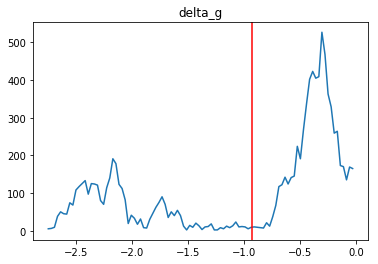

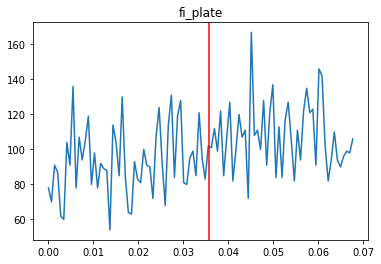

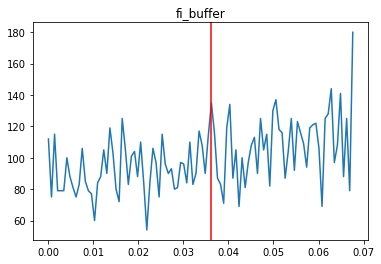

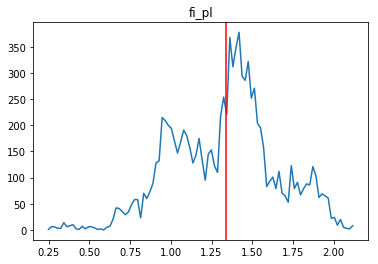

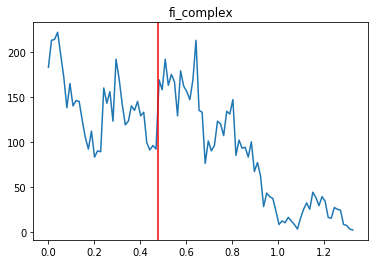

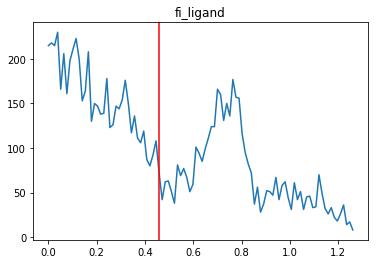

In [32]:
plt.clf()
labels = ['delta_g', 'fi_plate', 'fi_buffer', 'fi_pl', 'fi_complex', 'fi_ligand', 'concs_p_complex',
         'concs_l_complex', 'concs_l_ligand', 'jeffrey_log_sigma_complex', 'jeffrey_log_sigma_ligand']

plt.clf()
for idx, entry in enumerate(chain_states):
    
    if entry.numpy().ndim != 1:
        continue
    plt.figure()
    hist, edges = np.histogram(entry, bins=100)
    plt.plot(edges[:-1], hist)
    plt.axvline(entry.numpy().mean(), 0, 1, c = 'r')
    plt.title(labels[idx])
plt.show()